Compare different methods of calculating z-statistics from multiple regression with relatively low degrees of freedom. We use this to generate z-statistic maps corresponding to our PCA and ICA components in tedana.

In [1]:
%matplotlib inline
import os.path as op
import matplotlib.pyplot as plt

import numpy as np
import nibabel as nib
from nilearn import masking
from scipy import stats
from nilearn.mass_univariate import permuted_ols
from nimare.stats import p_to_z
import seaborn as sns

/Users/tsalo/.local/lib/python3.6/site-packages/scikit_learn-0.21.2-py3.6-macosx-10.7-x86_64.egg/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
def rmse(pred, truth):
    """
    https://stackoverflow.com/a/26072309/2589328
    """
    return np.sqrt(np.mean((pred - truth) ** 2))

In [3]:
voxel_idx = np.arange(1000, 2000, dtype=int)

In [4]:
data_dir = '/Users/tsalo/Documents/tsalo/tedana-comparison/sandbox/e5-checkerboard'
data_file = op.join(data_dir, 'ts_OC.nii.gz')
mixing_file = op.join(data_dir, 'mepca_mix.1D')
mixing = np.loadtxt(mixing_file)
mask = masking.compute_epi_mask(data_file)
data = masking.apply_mask(data_file, mask)
print(data.shape)
data = data[:, voxel_idx]
print(data.shape)
print(mixing.shape)
mixing = mixing[:, :50]  # Reduce to get some DOFs

(160, 24258)
(160, 1000)
(160, 159)


In [26]:
# Method 1: The tedana way
from tedana.stats import computefeats2
Z_MAX = 8
z_val_maps1 = computefeats2(data.T, mixing, normalize=False)
print(z_val_maps1.shape)
z_stat_maps1 = stats.zscore(z_val_maps1, axis=0)  # Normalize each component map across voxels
z_stat_maps1[np.abs(z_stat_maps1) > Z_MAX] = Z_MAX * np.sign(z_stat_maps1[np.abs(z_stat_maps1) > Z_MAX])

(1000, 50)


In [27]:
# Method 2: Adapted tedana way
data_vn = stats.zscore(data, axis=-1)  # normalize each voxel over time
mixing_z = stats.zscore(mixing, axis=0)  # normalize each component over time
z_val_maps2 = computefeats2(data_vn.T, mixing_z, normalize=False)
z_stat_maps2 = z_val_maps2# * np.sqrt((mixing.shape[0] - mixing.shape[1]) - 3)
# NOTE: Incorporating degrees of freedom *increases* RMSE

In [7]:
# Method 3: Nilearn
nilearn_test_maps = []
for i_test in range(50):
    pe_logp_vals, pe_t_vals, _ = permuted_ols(mixing, data, model_intercept=True, n_jobs=4, n_perm=500, verbose=0)
    pe_p_vals = np.power(10., -pe_logp_vals)
    pe_z_vals = p_to_z(pe_p_vals, tail='two')
    pe_z_vals *= np.sign(pe_t_vals)
    z_stat_maps3 = pe_z_vals
    nilearn_test_maps.append(z_stat_maps3)

In [8]:
# Ground truth: Nilearn + shit-ton of perms
pe_logp_vals, pe_t_vals, _ = permuted_ols(mixing, data, model_intercept=True, n_perm=50000, n_jobs=4, verbose=3)
pe_p_vals = np.power(10., -pe_logp_vals)
pe_z_vals = p_to_z(pe_p_vals, tail='two')
pe_z_vals *= np.sign(pe_t_vals)
z_stat_maps0 = pe_z_vals

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.5min finished


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


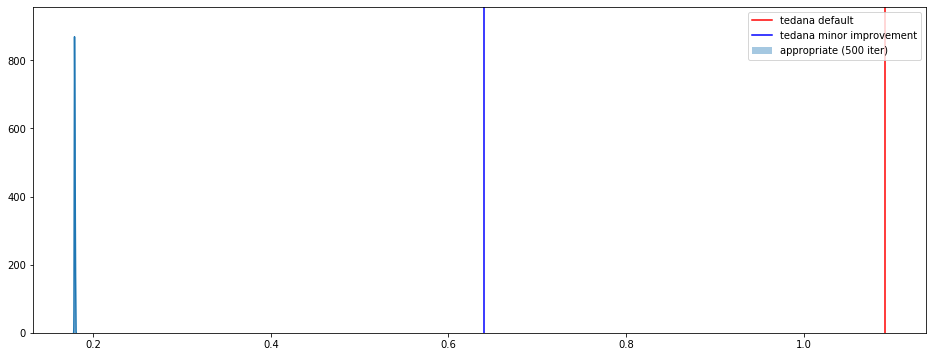

In [28]:
rmse1 = rmse(z_stat_maps1.T, z_stat_maps0)
rmse2 = rmse(z_stat_maps2.T, z_stat_maps0)
rmse3 = []
for i in range(len(nilearn_test_maps)):
    rmse3.append(rmse(nilearn_test_maps[i], z_stat_maps0))

fig, ax = plt.subplots(figsize=(16, 6))
sns.distplot(rmse3, ax=ax, label='appropriate (500 iter)')
ax.axvline(rmse1, color='red', label='tedana default')
ax.axvline(rmse2, color='blue', label='tedana minor improvement')
ax.legend()
fig.show()